In [1]:
import requests
import random
import json
import os
import csv
import matplotlib.pyplot as plt
import pandas as pd
import openweathermapy.core as owm
from citipy import citipy
from pprint import pprint
import numpy as np
from scipy.stats import sem,linregress
import matplotlib.style as style
from census import Census
import gmaps
import plotly.plotly as py
import plotly.graph_objs as go
import seaborn as sb

from config import (ckey, gkey, api_key_crime)

# Home Prices

In [2]:
# Home PriceFile to Load (Remember to Change These)
home_prices = pd.read_csv("input_data/HPI_master.csv")
home_prices.head()

,hpi_type,hpi_flavor,frequency,level,place_name,place_id,yr,period,index_nsa,price_nsa
0,traditional,purchase-only,monthly,USA or Census Division,East North Central Division,DV_ENC,1991,1,100.00,"$148,600"
1,traditional,purchase-only,monthly,USA or Census Division,East North Central Division,DV_ENC,1991,2,101.03,"$150,131"
2,traditional,purchase-only,monthly,USA or Census Division,East North Central Division,DV_ENC,1991,3,101.40,"$150,680"
3,traditional,purchase-only,monthly,USA or Census Division,East North Central Division,DV_ENC,1991,4,101.79,"$151,260"
4,traditional,purchase-only,monthly,USA or Census Division,East North Central Division,DV_ENC,1991,5,102.44,"$152,226"


In [3]:
#Clean up dataframe
home_prices_df = home_prices[["place_name","yr","period","price_nsa"]]
home_prices_df = home_prices_df.rename(columns={"place_name":"Place", "yr":"Year", "period":"Month", "price_nsa":"Price"})
home_prices_df.head()

,Place,Year,Month,Price
0,East North Central Division,1991,1,"$148,600"
1,East North Central Division,1991,2,"$150,131"
2,East North Central Division,1991,3,"$150,680"
3,East North Central Division,1991,4,"$151,260"
4,East North Central Division,1991,5,"$152,226"


In [4]:
#Split the Place into city and state
new = home_prices_df['Place'].str.split(", ", n=1,expand=True) 
home_prices_df['City']= new[0]
home_prices_df['State']= new[1]

#Clean up the Price data
home_prices_df['Price'] = home_prices_df['Price'].str.replace(r"$","")

# [x.strip('$') for x in home_prices_df.Price]
home_prices_df['Price'] = home_prices_df['Price'].str.replace(",","")
home_prices_df['Price'] = home_prices_df['Price'].str.replace(" ","")
home_prices_df['Price'] = round(pd.to_numeric(home_prices_df['Price']),2)

# Store the mean home prices for each year grouped by Place
mhp_df = home_prices_df.groupby(['State','Year'])['Price'].mean().to_frame().reset_index()
# Keep only 25 years of data
mhp_df = mhp_df[mhp_df['Year'] > 1990]
# Round Price to 2 decimal Places
mhp_df['Price'] = round(mhp_df['Price'],2)

#Drop the row if State characters are more than 2
mhp_df.drop(mhp_df[mhp_df['State'].map(len) > 2].index, inplace=True)

# Preview DataFrame
mhp_df.head()

,State,Year,Price
11,AK,1991,128022.62
12,AK,1992,136195.62
13,AK,1993,140638.62
14,AK,1994,147100.88
15,AK,1995,150769.75


In [5]:
# Minor Data Munging to Re-Format the Data Frames
p_mhp_df = mhp_df.pivot(index='Year', columns='State', values='Price')
# Find the mean value in US across all states and add a Mean column
p_mhp_df['United States'] = round(mhp_df.groupby('Year')['Price'].mean(),2)
p_mhp_df.head()

State,AK,AL,AR,AZ,CA,CO,CT,DE,FL,GA,...,TN,TX,UT,VA,VT,WA,WI,WV,WY,United States
Year,,,,,,,,,,,,,,,,,,,,,
1991,128022.62,132484.49,137407.92,137249.95,154051.50,121320.40,155192.61,147225.25,143235.67,136739.44,...,139026.42,135358.53,112300.70,136037.28,144814.50,115201.92,123949.31,124916.88,113983.75,133874.14
1992,136195.62,137324.69,138416.13,140997.56,153366.52,129326.58,152757.64,149970.50,146636.64,140183.83,...,139721.16,141668.77,120107.40,140836.59,146159.25,124816.60,130699.35,130188.62,120397.50,138274.55
1993,140638.62,143582.16,144847.42,146291.91,149276.88,141648.85,148877.50,153522.25,149628.68,144593.85,...,144463.86,148504.53,134714.10,144887.81,148039.00,135093.72,137913.63,136197.18,128739.62,143325.93
1994,147100.88,148493.75,151845.40,154051.18,145108.32,158788.40,146122.64,151583.25,150747.70,149710.55,...,151648.86,154741.80,156386.60,148102.66,149926.25,145610.22,149932.90,144523.42,142167.38,149529.09
1995,150769.75,154772.63,158682.65,162792.02,143402.81,170650.70,145388.57,152697.75,154552.83,155990.75,...,161315.19,158763.17,172810.65,152149.69,150948.00,151588.75,158492.17,151557.08,152170.12,155139.85


In [6]:
# Create a dataframe for % change against 1991 for plotting and 100 as a base
pp_mhp_df = pd.DataFrame(p_mhp_df.values / p_mhp_df.loc[:1991].values * 100, index = p_mhp_df.index, columns=p_mhp_df.columns)
# pp_mhp_df = pd.DataFrame((((p_mhp_df.values / p_mhp_df.loc[:1991].values)-1)*100)+100, index = p_mhp_df.index, columns=p_mhp_df.columns)
# pp_mhp_df = pd.DataFrame(((p_mhp_df.values - p_mhp_df.loc[:1991].values) / p_mhp_df.loc[:1991].values * 100) + 100, index = p_mhp_df.index, columns=p_mhp_df.columns)
pp_mhp_df.head()

State,AK,AL,AR,AZ,CA,CO,CT,DE,FL,GA,...,TN,TX,UT,VA,VT,WA,WI,WV,WY,United States
Year,,,,,,,,,,,,,,,,,,,,,
1991,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1992,106.384028,103.653409,100.733735,102.730500,99.555356,106.599203,98.431001,101.864660,102.374388,102.518944,...,100.499718,104.661871,106.951604,103.527937,100.928602,108.345937,105.445807,104.220198,105.626899,103.286975
1993,109.854509,108.376581,105.414171,106.587951,96.900634,116.756003,95.930792,104.277120,104.463281,105.744071,...,103.911084,109.711985,119.958380,106.505959,102.226642,117.266900,111.266154,109.030245,112.945591,107.060206
1994,114.902257,112.083875,110.507022,112.241338,94.194682,130.883512,94.155669,102.960090,105.244525,109.486005,...,109.079166,114.319947,139.257013,108.869172,103.529861,126.395654,120.963078,115.695669,124.726007,111.693782
1995,117.768055,116.823207,115.482899,118.609894,93.087578,140.661175,93.682663,103.717093,107.901077,114.078828,...,116.032039,117.290850,153.882077,111.844114,104.235418,131.585264,127.868538,121.326341,133.501591,115.884853


In [7]:
#Find standard deviation and sort them
sd_hp_df = pp_mhp_df.std()
sd_hp_df = sd_hp_df.sort_values(ascending=True)
sd_hp_df = sd_hp_df.to_frame('Std').reset_index()

# Return the state with the highest standard deviation and index of this state in the pivoted mean home price dataframe
state_h_std = sd_hp_df['State'][len(sd_hp_df)-1]
state_h_std_idx = p_mhp_df.columns.get_loc(state_h_std)

# Return the state with the lowest standard deviation and index of this state in the pivoted mean home price dataframe
state_l_std = sd_hp_df['State'][0]
state_l_std_idx = p_mhp_df.columns.get_loc(state_l_std)

# Return the NY state
state_ny_idx = p_mhp_df.columns.get_loc('NY')

In [8]:
#Import of states mapping

states_map = pd.read_csv("input_data/states.csv")
states_map.head()

,State,Abbreviation
0,Alabama,AL
1,Alaska,AK
2,Arizona,AZ
3,Arkansas,AR
4,California,CA


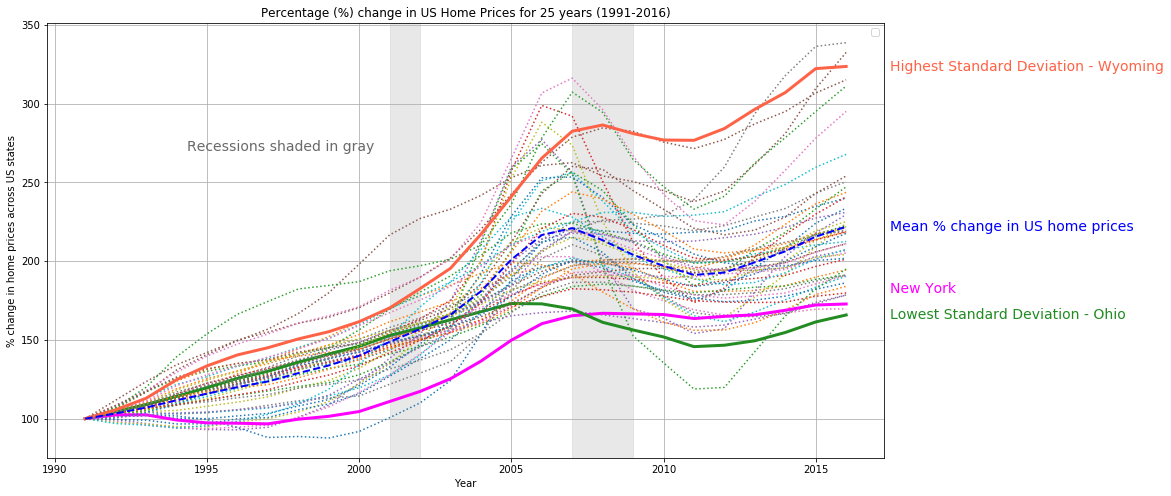

In [9]:
# Plot the data
ax = pp_mhp_df.plot(title = "Percentage (%) change in US Home Prices for 25 years (1991-2016)", grid=1, figsize=(15,8), ls=':')

# Change the line color of the US mean
line = plt.gca().get_lines()[-1]
line.set_color("blue")
line.set_ls("--")
line.set_linewidth(2)
y = line.get_ydata()[-1]
ax.annotate("Mean % change in US home prices", xy=(1,y), xytext=(6,0), color=line.get_color(), xycoords = ax.get_yaxis_transform(), textcoords="offset points", size=14, va="center")

# Change the line color of the state with the highest standard deviation
line = plt.gca().get_lines()[state_h_std_idx]
line.set_color("tomato")
line.set_ls("-")
line.set_linewidth(3)
y = line.get_ydata()[-1]
state_name = states_map['State'].loc[states_map['Abbreviation'] == state_h_std].reset_index()
label = "Highest Standard Deviation - "+ state_name['State'][0]
ax.annotate(label, xy=(1,y), xytext=(6,0), color=line.get_color(), xycoords = ax.get_yaxis_transform(), textcoords="offset points", size=14, va="center")

# Change the line color of the state with the lowest standard deviation
line = plt.gca().get_lines()[state_l_std_idx]
line.set_color("forestgreen")
line.set_ls("-")
line.set_linewidth(3)
y = line.get_ydata()[-1]
state_name = states_map['State'].loc[states_map['Abbreviation'] == state_l_std].reset_index()
label = "Lowest Standard Deviation - "+ state_name['State'][0]
ax.annotate(label, xy=(1,y), xytext=(6,0), color=line.get_color(), xycoords = ax.get_yaxis_transform(), textcoords="offset points", size=14, va="center")

# Change the line color of the NY state
line = plt.gca().get_lines()[state_ny_idx]
line.set_color("magenta")
line.set_ls("-")
line.set_linewidth(3)
y = line.get_ydata()[-1]
label = "New York"
ax.annotate(label, xy=(1,y+10), xytext=(6,0), color=line.get_color(), xycoords = ax.get_yaxis_transform(), textcoords="offset points", size=14, va="center")


# Plot the recessions

rec_bgn = [2001,2007]
rec_end = [2002,2009]

for i in range(len(rec_bgn)):
    plt.axvspan(rec_bgn[i], rec_end[i], color='lightgrey', alpha=0.5)

label = "Recessions shaded in gray"
ax.annotate(label, xy=(0.16,y+100), xytext=(6,0), color='dimgray', xycoords = ax.get_yaxis_transform(), textcoords="offset points", size=14, va="center")


# Add labels

plt.xlabel('Year')
plt.ylabel('% change in home prices across US states')
ax.legend("")
plt.savefig("images/1_US_home_prices_pct_change.png", bbox_inches='tight')
plt.show()

# Census Data (Population and Household Income)

In [10]:
#Define the years to retrieve
years = list(np.arange(2009,2017,1))
yearly_cencus_df = pd.DataFrame()

for year in years:
    c = Census(ckey, year)
    census_data = c.acs5.get(("NAME", "B19013_001E", "B01003_001E", "B19301_001E"), {'for': 'state:*'})
    c_cencus_data = pd.concat([pd.Series(c2) for c2 in census_data],1).T
    c_cencus_data['Year'] = year
    yearly_cencus_df = yearly_cencus_df.append(c_cencus_data,ignore_index=True)

yearly_cencus_df = yearly_cencus_df.rename(columns={"B01003_001E": "Population",
                                      "B19013_001E": "Household Income",
                                      "B19301_001E": "Per Capita Income",
                                      "NAME": "State", "state": "State Index"})
# Save as a csv
yearly_cencus_df.to_csv("output_data/census_data_states20092016.csv", encoding="utf-8", index=False)
yearly_cencus_df.head()

,State,Household Income,Population,Per Capita Income,State Index,Year
0,Alaska,64635,683142,29382,02,2009
1,Alabama,41216,4.63336e+06,22732,01,2009
2,Arkansas,38542,2.83814e+06,20977,05,2009
3,Arizona,50296,6.32486e+06,25203,04,2009
4,California,60392,3.63085e+07,29020,06,2009


In [11]:
# Read in the csv containing state centroid coordinates
centroids = pd.read_csv("input_data/state_centroids.csv")
centroids.head()

,State,Latitude,Longitude
0,Alabama,32.7794,-86.8287
1,Alaska,64.0685,-152.2782
2,Arizona,34.2744,-111.6602
3,Arkansas,34.8938,-92.4426
4,California,37.1841,-119.4696


In [12]:
# Merge the datasets using the state columns
census_data = pd.merge(yearly_cencus_df, centroids, on="State")

# Save the updated dataframe as a csv
census_data.to_csv("output_data/state_census_data2016.csv", encoding="utf-8", index=False)
census_data.head()

,State,Household Income,Population,Per Capita Income,State Index,Year,Latitude,Longitude
0,Alaska,64635,683142,29382,02,2009,64.0685,-152.2782
1,Alaska,66521,691189,30726,02,2010,64.0685,-152.2782
2,Alaska,69014,700703,31944,02,2011,64.0685,-152.2782
3,Alaska,69917,711139,32537,02,2012,64.0685,-152.2782
4,Alaska,70760,720316,32651,02,2013,64.0685,-152.2782


In [13]:
# Minor Data Munging to Re-Format the Data Frames
p_yc_df = yearly_cencus_df.pivot(index='Year', columns='State', values='Population')
p_yc_df

State,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
Year,,,,,,,,,,,,,,,,,,,,,
2009,4.63336e+06,683142,6.32486e+06,2.83814e+06,3.63085e+07,4.84321e+06,3.49449e+06,863832,588433,1.82224e+07,...,796513,6.15895e+06,2.3819e+07,2.65182e+06,620414,7.72173e+06,6.46576e+06,1.8114e+06,5.59942e+06,523949
2010,4.71265e+06,691189,6.24682e+06,2.87268e+06,3.66373e+07,4.88706e+06,3.54584e+06,881278,584400,1.85116e+07,...,799462,6.23497e+06,2.43119e+07,2.65724e+06,624258,7.84175e+06,6.5613e+06,1.8408e+06,5.63795e+06,545579
2011,4.74742e+06,700703,6.33737e+06,2.89593e+06,3.69692e+07,4.96606e+06,3.55817e+06,890856,593955,1.86888e+07,...,807697,6.29799e+06,2.47742e+07,2.71538e+06,624958,7.92619e+06,6.65284e+06,1.84637e+06,5.66489e+06,554697
2012,4.77733e+06,711139,6.41098e+06,2.91637e+06,3.73251e+07,5.04285e+06,3.57221e+06,900131,605759,1.88852e+07,...,815871,6.35323e+06,2.52089e+07,2.76623e+06,625498,8.01496e+06,6.73871e+06,1.85048e+06,5.68722e+06,562803
2013,4.79928e+06,720316,6.4797e+06,2.93337e+06,3.76592e+07,5.11933e+06,3.58356e+06,908446,619371,1.90912e+07,...,825198,6.40239e+06,2.56394e+07,2.81367e+06,625904,8.10065e+06,6.81958e+06,1.85362e+06,5.70687e+06,570134
2014,4.81768e+06,728300,6.56152e+06,2.94704e+06,3.80669e+07,5.19758e+06,3.59205e+06,917060,633736,1.93618e+07,...,834708,6.45136e+06,2.6092e+07,2.85811e+06,626358,8.18513e+06,6.89912e+06,1.85388e+06,5.72469e+06,575251
2015,4.83062e+06,733375,6.64193e+06,2.95821e+06,3.84215e+07,5.27891e+06,3.59322e+06,926454,647484,1.96458e+07,...,843190,6.49962e+06,2.65386e+07,2.90338e+06,626604,8.25663e+06,6.98546e+06,1.85142e+06,5.74212e+06,579679
2016,4.84116e+06,736855,6.72858e+06,2.96847e+06,3.86542e+07,5.3593e+06,3.58857e+06,934695,659009,1.99345e+07,...,851058,6.54801e+06,2.69564e+07,2.94843e+06,626249,8.3103e+06,7.07315e+06,1.84609e+06,5.7548e+06,583029


In [14]:
# Import Median Household Income
mhi_df = pd.read_csv("input_data/MHI_1984_2017.csv")
# Keep only 25 years of data
mhi_df = mhi_df[mhi_df['Year'] > 1990]
mhi_df = mhi_df[mhi_df['Year'] < 2017]
mhi_df = mhi_df.set_index('Year').rename_axis('State', axis=1)
mhi_df = mhi_df.sort_values('Year')
mhi_df.head()

State,United States,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
Year,,,,,,,,,,,,,,,,,,,,,
1991,30126,24346,40612,30737,23435,33664,31499,42154,32585,29885,...,24639,24453,27733,28016,29155,36137,33970,23147,31133,29050
1992,30636,25808,41802,29358,23882,34903,32484,40841,35678,30247,...,26259,24318,27953,34251,32755,38198,33900,20271,33308,30209
1993,31241,25082,42931,30510,23039,34073,34488,39516,36064,27304,...,27737,25102,28727,35786,31065,36433,35655,22421,31766,29442
1994,32264,27196,45367,31293,25565,35331,37833,41097,35873,30116,...,29733,28639,30755,35716,35802,37647,33533,23564,35388,33140
1995,34076,25991,47954,30863,25814,37009,40706,40243,34928,30748,...,29578,29015,32039,36480,33824,36222,35568,24880,40955,31529


In [15]:
# Create a dataframe for % change against 1991 for plotting
pp_yc_df = pd.DataFrame(mhi_df.values / mhi_df.loc[:1991].values * 100, index = mhi_df.index, columns=mhi_df.columns)
pp_yc_df.head()

State,United States,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
Year,,,,,,,,,,,,,,,,,,,,,
1991,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1992,101.692890,106.005093,102.930168,95.513550,101.907403,103.680490,103.127083,96.885230,109.492098,101.211310,...,106.574942,99.447921,100.793279,122.255140,112.347796,105.703296,99.793936,87.575064,106.986156,103.989673
1993,103.701122,103.023084,105.710135,99.261476,98.310220,101.214948,109.489190,93.741994,110.676692,91.363560,...,112.573562,102.654071,103.584178,127.734152,106.551192,100.819105,104.960259,96.863524,102.033212,101.349398
1994,107.096860,111.706235,111.708362,101.808895,109.088969,104.951877,120.108575,97.492527,110.090532,100.772963,...,120.674540,117.118554,110.896766,127.484295,122.798834,104.178543,98.713571,101.801529,113.667170,114.079174
1995,113.111598,106.756757,118.078400,100.409929,110.151483,109.936431,129.229499,95.466622,107.190425,102.887736,...,120.045456,118.656198,115.526629,130.211308,116.014406,100.235216,104.704151,107.486931,131.548518,108.533563


In [16]:
#Find standard deviation and sort them
sd_hp_df = pp_yc_df.std()
sd_hp_df = sd_hp_df.sort_values(ascending=True)
sd_hp_df = sd_hp_df.to_frame('Std').reset_index()
sd_hp_df

# Return the state with the highest standard deviation and index of this state in the pivoted mean home price dataframe
state_h_std = sd_hp_df['State'][len(sd_hp_df)-1]
state_h_std_idx = pp_yc_df.columns.get_loc(state_h_std)

# # Return the state with the lowest standard deviation and index of this state in the pivoted mean home price dataframe
state_l_std = sd_hp_df['State'][1]
state_l_std_idx = pp_yc_df.columns.get_loc(state_l_std)

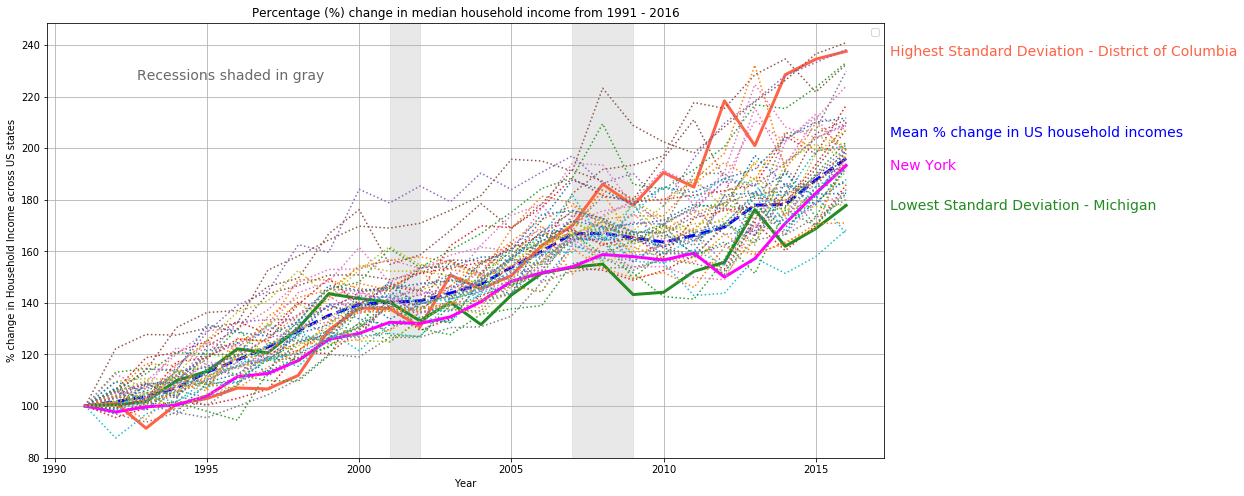

In [17]:
# Plot the data

ax1 = pp_yc_df.plot(title = "Percentage (%) change in median household income from 1991 - 2016", grid=1, figsize=(15,8), ls='dotted', legend='False')

# Change the line color of the US mean
line = plt.gca().get_lines()[0]
line.set_color("blue")
line.set_ls("--")
line.set_linewidth(3)
y = line.get_ydata()[-1]
ax1.annotate("Mean % change in US household incomes", xy=(1,y+10), xytext=(6,0), color=line.get_color(), xycoords = ax1.get_yaxis_transform(), textcoords="offset points", size=14, va="center")

# Change the line color of the state with the highest standard deviation
line = plt.gca().get_lines()[state_h_std_idx]
line.set_color("tomato")
line.set_ls("-")
line.set_linewidth(3)
y = line.get_ydata()[-1]
label = "Highest Standard Deviation - "+ state_h_std
ax1.annotate(label, xy=(1,y), xytext=(6,0), color=line.get_color(), xycoords = ax1.get_yaxis_transform(), textcoords="offset points", size=14, va="center")

# Change the line color of the state with the lowest standard deviation
line = plt.gca().get_lines()[state_l_std_idx]
line.set_color("forestgreen")
line.set_ls("-")
line.set_linewidth(3)
y = line.get_ydata()[-1]
label = "Lowest Standard Deviation - "+ state_l_std
ax1.annotate(label, xy=(1,y), xytext=(6,0), color=line.get_color(), xycoords = ax1.get_yaxis_transform(), textcoords="offset points", size=14, va="center")

# Change the line color of the NY state
line = plt.gca().get_lines()[state_ny_idx]
line.set_color("magenta")
line.set_ls("-")
line.set_linewidth(3)
y = line.get_ydata()[-1]
label = "New York"
ax1.annotate(label, xy=(1,y), xytext=(6,0), color=line.get_color(), xycoords = ax1.get_yaxis_transform(), textcoords="offset points", size=14, va="center")

# Plot the recessions

rec_bgn = [2001,2007]
rec_end = [2002,2009]

for i in range(len(rec_bgn)):
    plt.axvspan(rec_bgn[i], rec_end[i], color='lightgrey', alpha=0.5)

label = "Recessions shaded in gray"
ax1.annotate(label, xy=(0.1,y+35), xytext=(6,0), color='dimgray', xycoords = ax1.get_yaxis_transform(), textcoords="offset points", size=14, va="center")

# Add labels

plt.xlabel('Year')
plt.ylabel('% change in Household Income across US states')
plt.legend("")
plt.savefig("images/2_US_household_income_pct_change.png", bbox_inches='tight')
plt.show()

# GDP

In [18]:
# Load GDP
gdp = pd.read_csv("input_data/gdp_growth.csv")
gdp.head()

,Year,Nominal GDP (trillions),Real GDP (trillions),GDP Growth Rate,Events Affecting GDP
0,1929,$0.11,$1.11,NaN,Depression began.
1,1930,$0.09,$1.02,-8.50%,Smoot-Hawley.
2,1931,$0.08,$0.95,-6.40%,Dust Bowl.
3,1932,$0.06,$0.83,-12.90%,Hoover tax hikes.
4,1933,$0.06,$0.82,-1.20%,New Deal.


In [19]:
#Clean up the GDP data
gdp['GDP Growth Rate'] = gdp['GDP Growth Rate'].str.replace(r"%","")
gdp.head()

,Year,Nominal GDP (trillions),Real GDP (trillions),GDP Growth Rate,Events Affecting GDP
0,1929,$0.11,$1.11,NaN,Depression began.
1,1930,$0.09,$1.02,-8.50,Smoot-Hawley.
2,1931,$0.08,$0.95,-6.40,Dust Bowl.
3,1932,$0.06,$0.83,-12.90,Hoover tax hikes.
4,1933,$0.06,$0.82,-1.20,New Deal.


In [20]:
# Keep only data from 1991 - 2016
gdp = gdp[gdp['Year'] > 1990]
gdp = gdp[gdp['Year'] < 2017]
gdp['GDP Growth Rate'] = pd.to_numeric(gdp['GDP Growth Rate'])
gdp = gdp.reset_index()
yearly_gdp = gdp[["Year","GDP Growth Rate"]]
yearly_gdp.head()

,Year,GDP Growth Rate
0,1991,-0.1
1,1992,3.5
2,1993,2.8
3,1994,4.0
4,1995,2.7


In [21]:
# Adjust GDP growth rate to 1991 as a base
yearly_gdp['GDP Growth Rate'] = yearly_gdp['GDP Growth Rate'] + 0.1
gdp_adj = [100]
for i in range(len(yearly_gdp)):
    if i!=0:
        if i==1:
            gdp_adj.append(yearly_gdp['GDP Growth Rate'][i]+100)
        elif i>1:
            value = gdp_adj[i-1]
            gdp_adj.append(((yearly_gdp['GDP Growth Rate'][i]/100)+1)*value)
years = gdp['Year']
yearly_gdp_adj = pd.DataFrame({'Year':years,'GDP': gdp_adj})
yearly_gdp_adj.head()

C:\Users\thidar.tin\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,Year,GDP
0,1991,100.000000
1,1992,103.600000
2,1993,106.604400
3,1994,110.975180
4,1995,114.082485


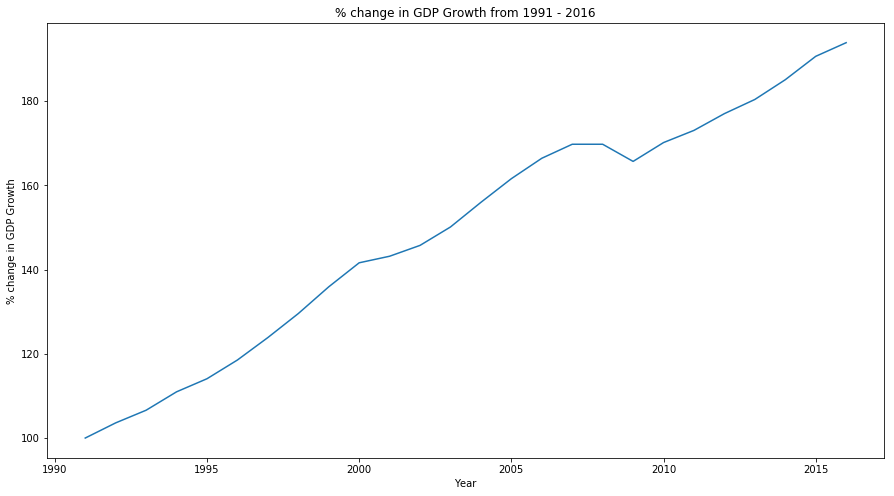

In [22]:
#Plot
plt.figure(figsize=(15,8))
plt.plot(yearly_gdp_adj['Year'],yearly_gdp_adj['GDP'])
plt.xlabel('Year')
plt.ylabel('% change in GDP Growth')
plt.title('% change in GDP Growth from 1991 - 2016')
plt.savefig("images/3_GDP_Growth_pct_change.png", bbox_inches='tight')
plt.show()

# Interest Rates

In [23]:
# Load Interest Rates
ir = pd.read_csv("input_data/fed-funds-rate-historical-chart.csv")
ir.head()

,date,value
0,1/07/1954,1.13
1,2/07/1954,1.25
2,3/07/1954,1.25
3,4/07/1954,1.25
4,5/07/1954,0.88


In [24]:
#Strip the dates, leaving only year and get average
ir['date']= [x[-4:] for x in ir['date']]
yearly_ir = ir.groupby('date').mean().reset_index()

# # Keep only data from 1991 - 2016
yearly_ir = yearly_ir[yearly_ir['date'] > '1990']
yearly_ir = yearly_ir[yearly_ir['date'] < '2017']
yearly_ir = yearly_ir.rename(columns={"date": "Year", " value": "Interest Rate (%)"})
yearly_ir = yearly_ir.reset_index()
yearly_ir = yearly_ir[['Year','Interest Rate (%)']]
yearly_ir['Year'] = pd.to_numeric(yearly_ir['Year'])
yearly_ir.head()

,Year,Interest Rate (%)
0,1991,5.685014
1,1992,3.521066
2,1993,3.021342
3,1994,4.206329
4,1995,5.834301


In [25]:
yearly_ir['Interest Rate'] = yearly_ir['Interest Rate (%)'] / yearly_ir['Interest Rate (%)'][0] * 100
yearly_ir.head()

,Year,Interest Rate (%),Interest Rate
0,1991,5.685014,100.000000
1,1992,3.521066,61.935921
2,1993,3.021342,53.145738
3,1994,4.206329,73.989774
4,1995,5.834301,102.625986


In [26]:
yearly_ir = yearly_ir.drop('Interest Rate (%)',axis=1)
yearly_ir.head()

,Year,Interest Rate
0,1991,100.000000
1,1992,61.935921
2,1993,53.145738
3,1994,73.989774
4,1995,102.625986


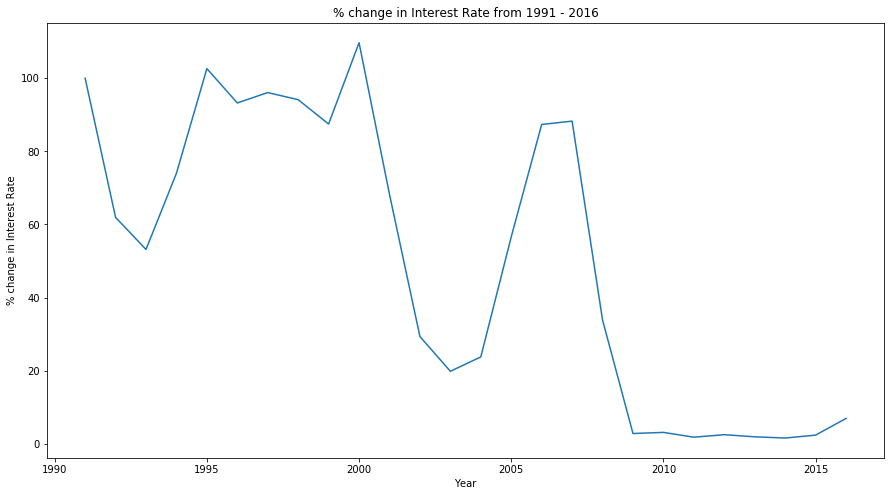

In [27]:
#Plot
plt.figure(figsize=(15,8))
#plt.plot(yearly_ir['Year'],yearly_ir['Interest Rate (%)'])
plt.plot(yearly_ir['Year'],yearly_ir['Interest Rate'])
plt.xlabel('Year')
plt.ylabel('% change in Interest Rate')
plt.title('% change in Interest Rate from 1991 - 2016')
plt.savefig("images/4_Interest_Rate_pct_change.png", bbox_inches='tight')
plt.show()

# Analysis (Home Prices, Household Income, GDP	and Interest Rate)

In [28]:
#Create a dataframe that shows the mean of the home prices, household income, gdp and interest rates
main_df = pd.DataFrame({'Home Prices':pp_mhp_df['United States'],'Household Income':pp_yc_df['United States']})
main_df = main_df.reset_index()
main_df = main_df.merge(yearly_gdp_adj,on='Year')
main_df = main_df.merge(yearly_ir,on='Year')
main_df = main_df.set_index('Year')
main_df.head()

,Home Prices,Household Income,GDP,Interest Rate
Year,,,,
1991,100.000000,100.000000,100.000000,100.000000
1992,103.286975,101.692890,103.600000,61.935921
1993,107.060206,103.701122,106.604400,53.145738
1994,111.693782,107.096860,110.975180,73.989774
1995,115.884853,113.111598,114.082485,102.625986


In [29]:
main_df.describe()

,Home Prices,Household Income,GDP,Interest Rate
count,26.000000,26.000000,26.000000,26.000000
mean,166.020426,145.885231,149.363626,50.088771
std,42.867809,27.814845,28.733192,40.113475
min,100.000000,100.000000,100.000000,1.556604
25%,124.944562,124.394211,125.290084,4.054240
50%,173.401162,145.475669,153.055554,54.867159
75%,203.273168,166.594470,170.074805,88.057402
max,221.874135,195.973578,193.897019,109.717092


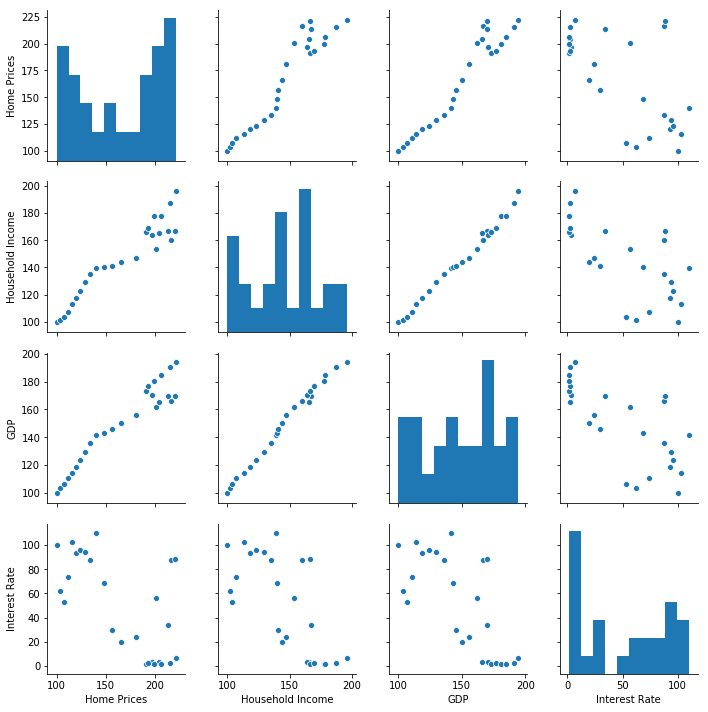

In [30]:
hp_hi_gdp_ir = sb.pairplot(main_df)
hp_hi_gdp_ir.savefig("images/5_US_pair_plot.png")


In [31]:
#Linear Regression Result between Home Prices and Household Income
linregress(main_df['Home Prices'], main_df['Household Income'])

LinregressResult(slope=0.6180412025442654, intercept=43.277766942769574, rvalue=0.952515528541622, pvalue=6.799879346819933e-14, stderr=0.04032856750561952)

In [32]:
#Linear Regression Result between Home Prices and GDP
linregress(main_df['Home Prices'], main_df['GDP'])

LinregressResult(slope=0.6443029694740582, intercept=42.396172716258604, rvalue=0.9612526376303705, pvalue=6.200383644642083e-15, stderr=0.03771679750116573)

In [33]:
#Linear Regression Result between Home Prices and Interest Rate
linregress(main_df['Home Prices'], main_df['Interest Rate'])

LinregressResult(slope=-0.6013563387941091, intercept=149.92620682528099, rvalue=-0.6426476093037841, pvalue=0.0003996975507456346, stderr=0.14634366423513998)

In [34]:
main_corr = main_df.corr()
main_corr

,Home Prices,Household Income,GDP,Interest Rate
Home Prices,1.000000,0.952516,0.961253,-0.642648
Household Income,0.952516,1.000000,0.995202,-0.696658
GDP,0.961253,0.995202,1.000000,-0.716882
Interest Rate,-0.642648,-0.696658,-0.716882,1.000000


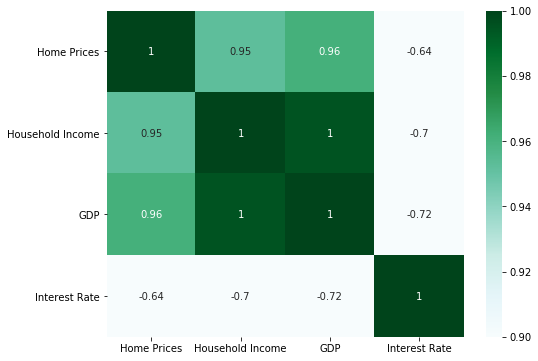

In [35]:
# plot the heatmap
hp_hi_gdp_ir1 = plt.figure(figsize=(8,6))
sb.heatmap(main_corr, xticklabels=main_corr.columns, yticklabels=main_corr.columns, cmap='BuGn', vmin = 0.9, annot = True)
hp_hi_gdp_ir1.savefig("images/6_US_heatmap.png", bbox_inches='tight')

# Crime Rate

In [36]:
# Base URL to retrieve crime data
# url = "https://api.usa.gov/crime/fbi/sapi"

In [37]:
# Parameters for URL
# stateAbbr = ["SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
# offense = ["aggravated-assault", "burglary", "larceny", "motor-vehicle-theft", "homicide", "rape", "robbery", "arson", "violent-crime", "property-crime"]
# since = "2009"
# until = "2016"

In [38]:
# Request URL and convert into JSON format (https://crime-data-explorer.fr.cloud.gov/api)
# crime = pd.DataFrame()

# for o in offense:
    # for s in stateAbbr:
        # request_url = url + "/api" + "/summarized" + "/state/" + s + "/" + o + "/" + since + "/" + until + "?api_key=" + api_key_crime
        # crime_data = requests.get(request_url).json()
        # c_crime_data = pd.concat([pd.Series(c3) for c3 in crime_data["results"]],1).T
        # crime = crime.append(c_crime_data, ignore_index=True)

In [39]:
# Export into CSV file   
# crime.to_csv("output_data/crime5.csv")
# crime.head()

In [40]:
# Import crime CSV file 
crime_df = pd.read_csv("input_data/crime_states2.csv")
crime_df.head()

,data_year,offense,state_abbr,cleared,actual
0,2009,all,AL,1982,63942
1,2009,all,AK,8018,29707
2,2009,all,AZ,236,620
3,2009,all,AR,22,511
4,2009,all,CA,2034,11939


In [41]:
# Drop unnecessary columns
crime_df1 = crime_df.drop(["offense", "cleared"], axis = 1)
crime_df1.head()

,data_year,state_abbr,actual
0,2009,AL,63942
1,2009,AK,29707
2,2009,AZ,620
3,2009,AR,511
4,2009,CA,11939


In [42]:
# Import state data CSV file
state_df = pd.read_csv("input_data/states.csv")
state_df.head()

,State,Abbreviation
0,Alabama,AL
1,Alaska,AK
2,Arizona,AZ
3,Arkansas,AR
4,California,CA


In [43]:
# Merge crime data with state data
crime_df2 = crime_df1.merge(state_df, left_on="state_abbr", right_on="Abbreviation")
crime_df2 = crime_df2.drop(["Abbreviation"], axis = 1) 
crime_df2 = crime_df2.rename(columns={"data_year": "Year"})
crime_df2.head()

,Year,state_abbr,actual,State
0,2009,AL,63942,Alabama
1,2010,AL,37369,Alabama
2,2011,AL,58826,Alabama
3,2012,AL,52547,Alabama
4,2013,AL,16243,Alabama


In [44]:
# Import population data CSV file
population_df = pd.read_csv("output_data/census_data_states20092016.csv")
population_df.head()

,State,Household Income,Population,Per Capita Income,State Index,Year
0,Alaska,64635.0,683142.0,29382.0,2,2009
1,Alabama,41216.0,4633360.0,22732.0,1,2009
2,Arkansas,38542.0,2838143.0,20977.0,5,2009
3,Arizona,50296.0,6324865.0,25203.0,4,2009
4,California,60392.0,36308527.0,29020.0,6,2009


In [45]:
# Merge crime data with population data
crime_df3 = pd.merge(crime_df2, population_df, how="inner", on=["Year", "State"])
crime_df3 = crime_df3.drop(["Household Income", "Per Capita Income", "State Index"], axis = 1) 
crime_df3 = crime_df3.rename(columns={"state_abbr": "StateAbbr", "actual": "Number of Crime"})
crime_df3.head()

,Year,StateAbbr,Number of Crime,State,Population
0,2009,AL,63942,Alabama,4633360.0
1,2010,AL,37369,Alabama,4712651.0
2,2011,AL,58826,Alabama,4747424.0
3,2012,AL,52547,Alabama,4777326.0
4,2013,AL,16243,Alabama,4799277.0


In [46]:
# Calculate crime rate, i.e. (Number of Crime / Population) * 100
nb_crime = crime_df3["Number of Crime"]
pop = crime_df3["Population"]
crime_rate = (nb_crime / pop) * 100
crime_rate.head()

0    1.380035
1    0.792951
2    1.239114
3    1.099925
4    0.338447
dtype: float64

In [47]:
# Create a dataframe to hold crime rate
year = crime_df3["Year"]
stateabbr = crime_df3["StateAbbr"]
state = crime_df3["State"]

crime_df4 = pd.DataFrame({"Year": year, "StateAbbr": stateabbr, 
                          "State": state, "Number of Crime": nb_crime,
                          "Population": pop, "Crime Rate": crime_rate})
crime_df4.head()

,Year,StateAbbr,State,Number of Crime,Population,Crime Rate
0,2009,AL,Alabama,63942,4633360.0,1.380035
1,2010,AL,Alabama,37369,4712651.0,0.792951
2,2011,AL,Alabama,58826,4747424.0,1.239114
3,2012,AL,Alabama,52547,4777326.0,1.099925
4,2013,AL,Alabama,16243,4799277.0,0.338447


In [48]:
# Check which state has highest crime rate
max_state = crime_df4[crime_df4["Crime Rate"]==crime_df4["Crime Rate"].max()]["State"]
max_state.values[0]

'Hawaii'

In [49]:
# Minor Data Munging to Re-Format the Data Frames
crime_df5 = crime_df4.pivot(index="Year", columns="State", values="Crime Rate")
crime_df5

State,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Florida,Georgia,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
Year,,,,,,,,,,,,,,,,,,,,,
2009,1.380035,4.348583,0.009803,0.018005,0.032882,0.655970,0.050937,0.654873,0.129752,0.005517,...,0.008035,0.053369,0.013179,0.059431,0.088812,0.018597,0.026200,0.006404,0.020609,0.355187
2010,0.792951,3.752519,0.011254,0.019007,0.031048,0.644968,0.051243,0.650192,0.106647,0.006136,...,0.009506,0.054499,0.010485,0.051858,0.118701,0.016272,0.028348,0.006953,0.015892,0.370982
2011,1.239114,3.498629,0.012182,0.017369,0.029990,0.616585,0.055113,0.704154,0.101537,0.016676,...,0.007057,0.055970,0.012913,0.065994,0.068965,0.018092,0.026184,0.010399,0.020336,0.352625
2012,1.099925,3.790117,0.013087,0.016253,0.031863,0.607672,0.055680,0.680679,0.097495,0.012919,...,0.127349,0.047582,0.012131,0.070240,0.051639,0.015608,0.023640,0.012429,0.020010,0.344881
2013,0.338447,4.160674,0.012269,0.010841,0.027250,0.586034,0.032258,0.559967,0.087501,0.008440,...,0.013815,0.034987,0.004084,0.016420,0.015338,0.012258,0.021306,0.002050,0.021378,0.268007
2014,0.263882,5.118358,0.011872,0.009908,0.024037,0.542541,0.032572,0.494733,0.082859,0.004249,...,0.010063,0.033187,0.003365,0.025296,0.010218,0.011814,0.020829,0.000216,0.014289,0.280399
2015,0.304329,5.331106,0.007407,0.012339,0.023763,0.578529,0.029361,0.521774,0.080516,0.005456,...,0.010318,0.031710,0.003429,0.022147,0.011810,0.012220,0.018252,0.004375,0.015743,0.214429
2016,0.269832,6.249669,0.006658,0.009432,0.025744,0.618328,0.027504,0.499200,0.083082,0.013189,...,0.005640,0.036179,0.002834,0.024725,0.006547,0.011913,0.013346,0.009859,0.017151,0.167402


In [50]:
# Find the index number for maximum crime value
crime_max_idx = crime_df5.columns.get_loc(max_state.values[0])
crime_max_idx

10

In [51]:
# Filter only NY data and export into CSV file
crime_df4_ny = crime_df4.loc[crime_df4["StateAbbr"] == "NY", :]
crime_df4_ny
crime_df4_ny.to_csv("output_data/crime_df4_ny.csv")

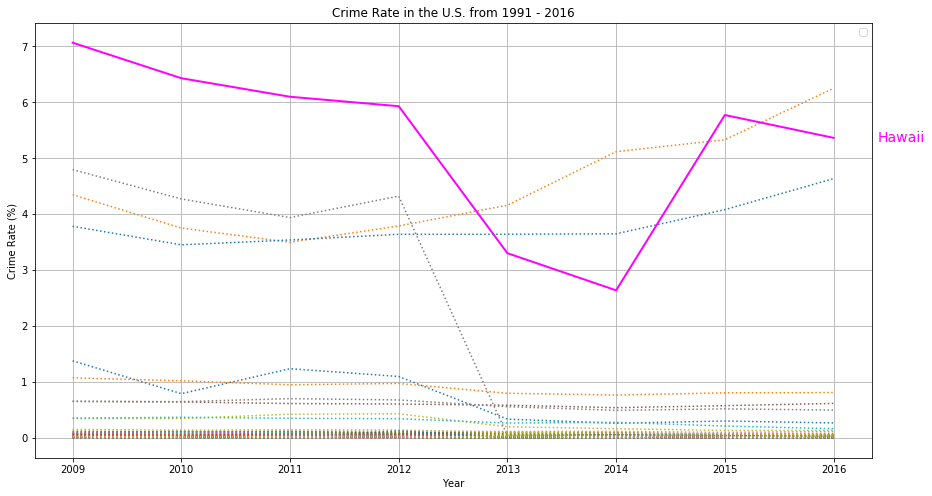

In [52]:
# Plot the crime rate 

crime_plot = crime_df5.plot(title = "Crime Rate in the U.S. from 1991 - 2016", grid=1, figsize=(15,8), ls="dotted")

# Change the plot design 
line = plt.gca().get_lines()[crime_max_idx]
line.set_color("magenta")
line.set_ls("-")
line.set_linewidth(2)
y = line.get_ydata()[-1]
label = max_state.values[0]
crime_plot.annotate(label, xy=(1,y), xytext=(6,0), color=line.get_color(), xycoords = crime_plot.get_yaxis_transform(), textcoords="offset points", size=14, va="center")
plt.xlabel("Year")
plt.ylabel("Crime Rate (%)")
plt.legend("")
plt.savefig("images/7_crime_plot", bbox_inches="tight")
plt.show()

In [53]:
# Get 2016 Crime Rate for all states

crime_df_hm = crime_df4.loc[crime_df4['Year']==2016]
crime_df_hm.head()

,Year,StateAbbr,State,Number of Crime,Population,Crime Rate
7,2016,AL,Alabama,13063,4841164.0,0.269832
15,2016,AK,Alaska,46051,736855.0,6.249669
23,2016,AZ,Arizona,448,6728577.0,0.006658
31,2016,AR,Arkansas,280,2968472.0,0.009432
39,2016,CA,California,9951,38654206.0,0.025744


In [54]:
# Merge it with coordinates
crime_df_hm1 = pd.merge(crime_df_hm, centroids, on="State")
crime_df_hm1.head()

,Year,StateAbbr,State,Number of Crime,Population,Crime Rate,Latitude,Longitude
0,2016,AL,Alabama,13063,4841164.0,0.269832,32.7794,-86.8287
1,2016,AK,Alaska,46051,736855.0,6.249669,64.0685,-152.2782
2,2016,AZ,Arizona,448,6728577.0,0.006658,34.2744,-111.6602
3,2016,AR,Arkansas,280,2968472.0,0.009432,34.8938,-92.4426
4,2016,CA,California,9951,38654206.0,0.025744,37.1841,-119.4696


In [55]:
# Configure gmaps
gmaps.configure(api_key=gkey)

# Store 'Lat' and 'Lng' into  locations 
locations = crime_df_hm1[["Latitude", "Longitude"]].astype(float)

# Convert Crime Rate to float and store
crime_rate = crime_df_hm1["Crime Rate"].astype(float)

# Create a Crime Rate Heatmap layer
fig = gmaps.figure()

heat_layer = gmaps.heatmap_layer(locations, weights=crime_rate, 
                                 dissipating=False, max_intensity=1,
                                 point_radius = 1)

# Adjust heat_layer setting to help with heatmap dissipating on zoom
heat_layer.dissipating = False
heat_layer.max_intensity = 1.5
heat_layer.point_radius = 2

fig.add_layer(heat_layer)

fig

Figure(layout=FigureLayout(height='420px'))

# Weather data

In [56]:
def find_all(a_str, sub):
    return [i for i in range(len(a_str)) if a_str.startswith(sub, i)]

def get_temp(start_ind):
    end_ind = data.find('</td', start_ind)
    return data[start_ind + len('class="align_right temperature_red">') : end_ind]

In [57]:
def get_temp(start_ind):
    end_ind = data.find('</td', start_ind)
    return data[start_ind + len('class="align_right temperature_red">') : end_ind]

In [58]:
def get_state_url(start_ind, data):
    end_ind = data.find('"', start_ind + len('<a class="province" href="'))
    return data[start_ind + len('<a class="province" href="') : end_ind]

In [59]:
def find_all(a_str, sub):
    return [i for i in range(len(a_str)) if a_str.startswith(sub, i)]

def get_temp(start_ind):
    end_ind = data.find('</td', start_ind)
    return data[start_ind + len('class="align_right temperature_red">') : end_ind]

columns = ['state']
for i in range(12):
    columns.append(str(i+1))

In [60]:
r = requests.get(url='https://www.usclimatedata.com/climate/united-states/us')
d = r.text
state_url_indexes = find_all(d, '<a class="province" href="')
state_urls = [get_state_url(i, d) for i in state_url_indexes]

In [61]:
state_urls

['/climate/alabama/united-states/3170',
 '/climate/kentucky/united-states/3187',
 '/climate/north-dakota/united-states/3204',
 '/climate/alaska/united-states/3171',
 '/climate/louisiana/united-states/3188',
 '/climate/ohio/united-states/3205',
 '/climate/arizona/united-states/3172',
 '/climate/maine/united-states/3189',
 '/climate/oklahoma/united-states/3206',
 '/climate/arkansas/united-states/3173',
 '/climate/maryland/united-states/1872',
 '/climate/oregon/united-states/3207',
 '/climate/california/united-states/3174',
 '/climate/massachusetts/united-states/3191',
 '/climate/pennsylvania/united-states/3208',
 '/climate/colorado/united-states/3175',
 '/climate/michigan/united-states/3192',
 '/climate/rhode-island/united-states/3209',
 '/climate/connecticut/united-states/3176',
 '/climate/minnesota/united-states/3193',
 '/climate/south-carolina/united-states/3210',
 '/climate/delaware/united-states/3177',
 '/climate/mississippi/united-states/3194',
 '/climate/south-dakota/united-states

In [62]:
all_state_data = pd.DataFrame(columns=columns)
ct = 0
for state_url in state_urls:
    row = pd.Series()
    api_url='https://www.usclimatedata.com' + state_url
    r = requests.get(url=api_url)
    data = r.text
    state_name = state_url.split('/')[2]
    state_name = state_name.replace('-', ' ')
    row['state'] = state_name
    print ("Processing state " + state_name)
    avg_temp_indexes = find_all(data, 'class="align_right temperature_red">')
    temps = [get_temp(i) for i in avg_temp_indexes]
    for index, temp in enumerate(temps):
#         print ("Month", index, temp)
        index_str = str(index + 1)
        row[index_str] = temp
    all_state_data.loc[ct] = row
    ct += 1
    

Processing state alabama
Processing state kentucky
Processing state north dakota
Processing state alaska
Processing state louisiana
Processing state ohio
Processing state arizona
Processing state maine
Processing state oklahoma
Processing state arkansas
Processing state maryland
Processing state oregon
Processing state california
Processing state massachusetts
Processing state pennsylvania
Processing state colorado
Processing state michigan
Processing state rhode island
Processing state connecticut
Processing state minnesota
Processing state south carolina
Processing state delaware
Processing state mississippi
Processing state south dakota
Processing state district of columbia
Processing state missouri
Processing state tennessee
Processing state florida
Processing state montana
Processing state texas
Processing state georgia
Processing state nebraska
Processing state utah
Processing state hawaii
Processing state nevada
Processing state vermont
Processing state idaho
Processing state ne

In [63]:
all_state_data

,state,1,2,3,4,5,6,7,8,9,10,11,12
0,alabama,57,62,70,77,84,90,92,92,87,78,69,60
1,kentucky,40,45,55,66,75,83,87,86,79,68,55,44
2,north dakota,23,28,40,57,68,77,85,83,72,58,40,26
3,alaska,23,27,34,44,56,63,65,64,55,40,28,25
4,louisiana,62,65,72,78,85,89,91,91,87,80,72,64
5,ohio,36,40,52,63,73,82,85,84,77,65,52,41
6,arizona,67,71,77,85,95,104,106,104,100,89,76,66
7,maine,28,32,40,53,65,74,79,78,70,57,45,33
8,oklahoma,50,55,63,72,80,88,94,93,85,73,62,51
9,arkansas,51,55,64,73,81,89,92,93,86,75,63,52


In [64]:
US_cold = pd.read_csv("input_data/US_cold.csv")
US_hot = pd.read_csv("input_data/US_hot.csv")
US_Summer = pd.read_csv("input_data/US_Summer.csv")
US_Winter = pd.read_csv("input_data/US_Winter.csv")

In [65]:
US_Winter.head(2)

,State,state,Housing Price,Cold Winter
0,SD,south dakota,325129.25,22
1,AK,alaska,307330.75,23


In [66]:
US_hot.head(2)

,State,state,Housing Price,Hot Summer
0,UT,utah,349480.5,90
1,CO,colorado,403398.6,90


In [67]:
US_cold.head(2)
US_Winter.head(2)
%matplotlib notebook
import matplotlib.pyplot as plt

import numpy as np

State_Winter = US_Winter.iloc[:, 3]
State_Housing = US_Winter.iloc[:, 2]
State_Summer = US_Summer.iloc[:, 3]
q1_cold = np.percentile(State_Winter, 25)
q3_cold = np.percentile(State_Winter,75)

iqr_cold = (q3_cold - q1_cold)


In [68]:
lower_boundary_cold = q1_cold - (1.5 * iqr_cold)
lower_boundary_cold

7.5

In [69]:
upper_boundary_cold = q3_cold + (1.5 * iqr_cold)
upper_boundary_cold

75.5

In [70]:
State_Winter[State_Winter <= lower_boundary_cold]

Series([], Name: Cold Winter, dtype: int64)

In [71]:
State_Winter[State_Winter >= upper_boundary_cold]

48    80
Name: Cold Winter, dtype: int64

<IPython.core.display.Javascript object>


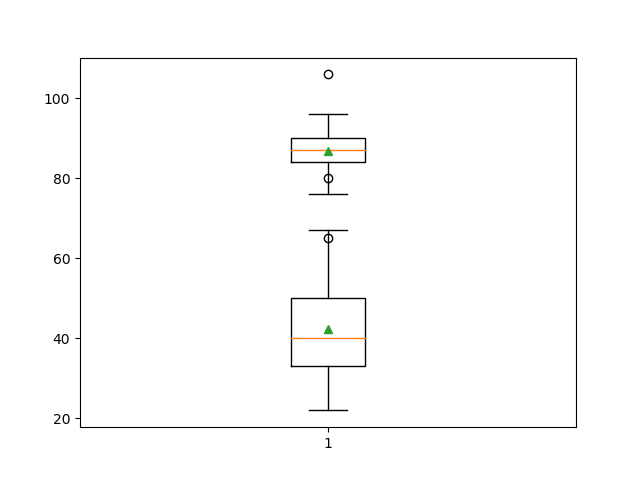

In [72]:
plt.boxplot(State_Winter, showmeans=True)
plt.grid()
plt.savefig("images/8_US_Temp_Range_Winter_Summer.png", bbox_inches='tight')
plt.show()

In [73]:
q1_hot = np.percentile(State_Summer, 25)
q3_hot = np.percentile(State_Summer,75)
iqr_hot = (q3_hot - q1_hot)

In [74]:
lower_boundary_hot = q1_hot - (1.5 * iqr_hot)
lower_boundary_hot

75.0

In [75]:
upper_boundary_hot = q3_hot + (1.5 * iqr_hot)
upper_boundary_hot

99.0

In [76]:
State_Summer[State_Summer <= lower_boundary_hot]

0    65
Name: Hot Summer, dtype: int64

In [77]:
State_Summer[State_Summer >= upper_boundary_hot]

48    106
Name: Hot Summer, dtype: int64

In [78]:
plt.boxplot(State_Summer, showmeans=True)
plt.grid()
plt.show()

In [79]:
State_cold = US_cold.iloc[:, 0]
Housing_cold = US_cold.iloc[:,2]
Winter_Temp = US_cold.iloc[:,3]

In [80]:
State_cold.head()
Winter_Temp.head()
Housing_cold.head(2)

0    325129.25
1    307330.75
Name: Housing Price, dtype: float64

In [81]:
from scipy import stats
vc_slope, vc_int, vc_r, vc_p, vc_std_err = stats.linregress(
    Winter_Temp, Housing_cold)
vc_fit = vc_slope * Winter_Temp + vc_int

<IPython.core.display.Javascript object>


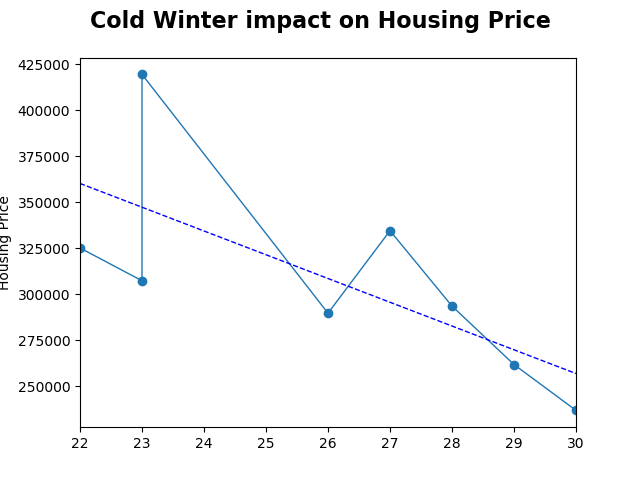

In [82]:
fig, (ax20) = plt.subplots(1, sharex=True)
fig.suptitle("Cold Winter impact on Housing Price", fontsize=16, fontweight="bold")

ax20.set_xlim(min(Winter_Temp), max(Winter_Temp))
ax20.plot(Winter_Temp, Housing_cold, linewidth=1, marker="o")
ax20.plot(Winter_Temp, vc_fit, "b--", linewidth=1)
ax20.set_ylabel("Housing Price")
plt.savefig("images/9_Cold_Winter.png", bbox_inches='tight')

<IPython.core.display.Javascript object>


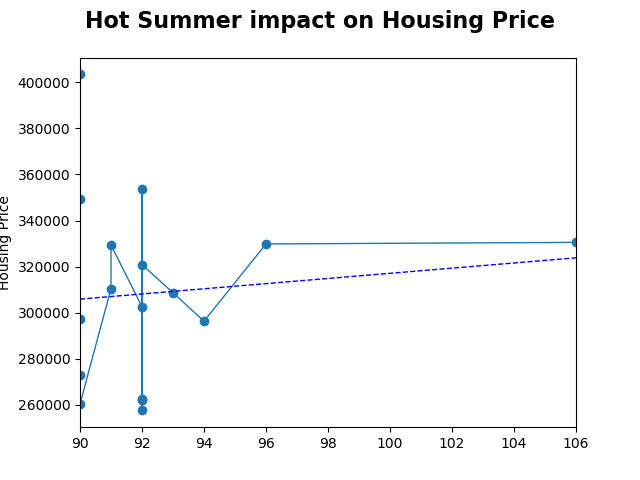

In [83]:
State_hot = US_hot.iloc[:, 0]
Housing_hot = US_hot.iloc[:,2]
Summer_Temp = US_hot.iloc[:,3]

vc_slope, vc_int, vc_r, vc_p, vc_std_err = stats.linregress(
    Summer_Temp, Housing_hot)
vc_fit = vc_slope * Summer_Temp + vc_int

fig, (ax20) = plt.subplots(1, sharex=True)
fig.suptitle("Hot Summer impact on Housing Price", fontsize=16, fontweight="bold")

ax20.set_xlim(min(Summer_Temp), max(Summer_Temp))
ax20.plot(Summer_Temp, Housing_hot, linewidth=1, marker="o")
ax20.plot(Summer_Temp, vc_fit, "b--", linewidth=1)
ax20.set_ylabel("Housing Price")
plt.savefig("images/10_Hot_Summer.png", bbox_inches='tight')

# Analysis (Home Prices, Household Income, Crime Rate, Weather in NY)

In [84]:
main_ny_df = pd.DataFrame({'Home Prices':p_mhp_df['NY'],'Household Income':mhi_df['New York']})
main_ny_df = main_ny_df.reset_index()
# Keep only data from 2009 - 2016
main_ny_df = main_ny_df[main_ny_df['Year'] > 2008]
main_ny_df = main_ny_df[main_ny_df['Year'] < 2017]
main_ny_df.head()

,Year,Home Prices,Household Income
18,2009,256457.10,50216
19,2010,255806.25,49781
20,2011,251890.58,50636
21,2012,254002.98,47680
22,2013,255519.72,49966


In [85]:
# Read in crime data and merge
ny_crimes = pd.read_csv("output_data/crime_df4_ny.csv")
ny_crimes = ny_crimes [['Year','Crime Rate']]
main_ny_df = main_ny_df.merge(ny_crimes, on='Year')
main_ny_df2 = main_ny_df
main_ny_df.head()

,Year,Home Prices,Household Income,Crime Rate
0,2009,256457.10,50216,0.060312
1,2010,255806.25,49781,0.063891
2,2011,251890.58,50636,0.062831
3,2012,254002.98,47680,0.058073
4,2013,255519.72,49966,0.051501


In [86]:
# Read in weather data and merge

ny_weather = pd.read_csv("input_data/New_York__City_10_years__temperature.csv")
# Keep only data from 2009 - 2016
ny_weather = ny_weather[ny_weather['Year'] > 2008]
ny_weather = ny_weather[ny_weather['Year'] < 2017]
main_ny_df = main_ny_df.merge(ny_weather, on='Year')
main_ny_df = main_ny_df.set_index('Year')
main_ny_df

,Home Prices,Household Income,Crime Rate,Annual Temperature
Year,,,,
2009,256457.10,50216,0.060312,54.0
2010,255806.25,49781,0.063891,56.7
2011,251890.58,50636,0.062831,56.4
2012,254002.98,47680,0.058073,57.3
2013,255519.72,49966,0.051501,55.3
2014,259950.50,54310,0.048723,54.4
2015,265114.58,58005,0.041803,56.7
2016,266112.37,61437,0.045407,57.2


In [87]:
# Normalize the data for plotting
main_ny_df1 =  pd.DataFrame(main_ny_df / main_ny_df.loc[2009,:] * 100, index = main_ny_df.index, columns=main_ny_df.columns)
main_ny_df1

,Home Prices,Household Income,Crime Rate,Annual Temperature
Year,,,,
2009,100.000000,100.000000,100.000000,100.000000
2010,99.746215,99.133742,105.932904,105.000000
2011,98.219383,100.836387,104.176760,104.444444
2012,99.043068,94.949817,96.286521,106.111111
2013,99.634489,99.502151,85.390300,102.407407
2014,101.362177,108.152780,80.784968,100.740741
2015,103.375800,115.510993,69.311089,105.000000
2016,103.764867,122.345468,75.286253,105.925926


<IPython.core.display.Javascript object>


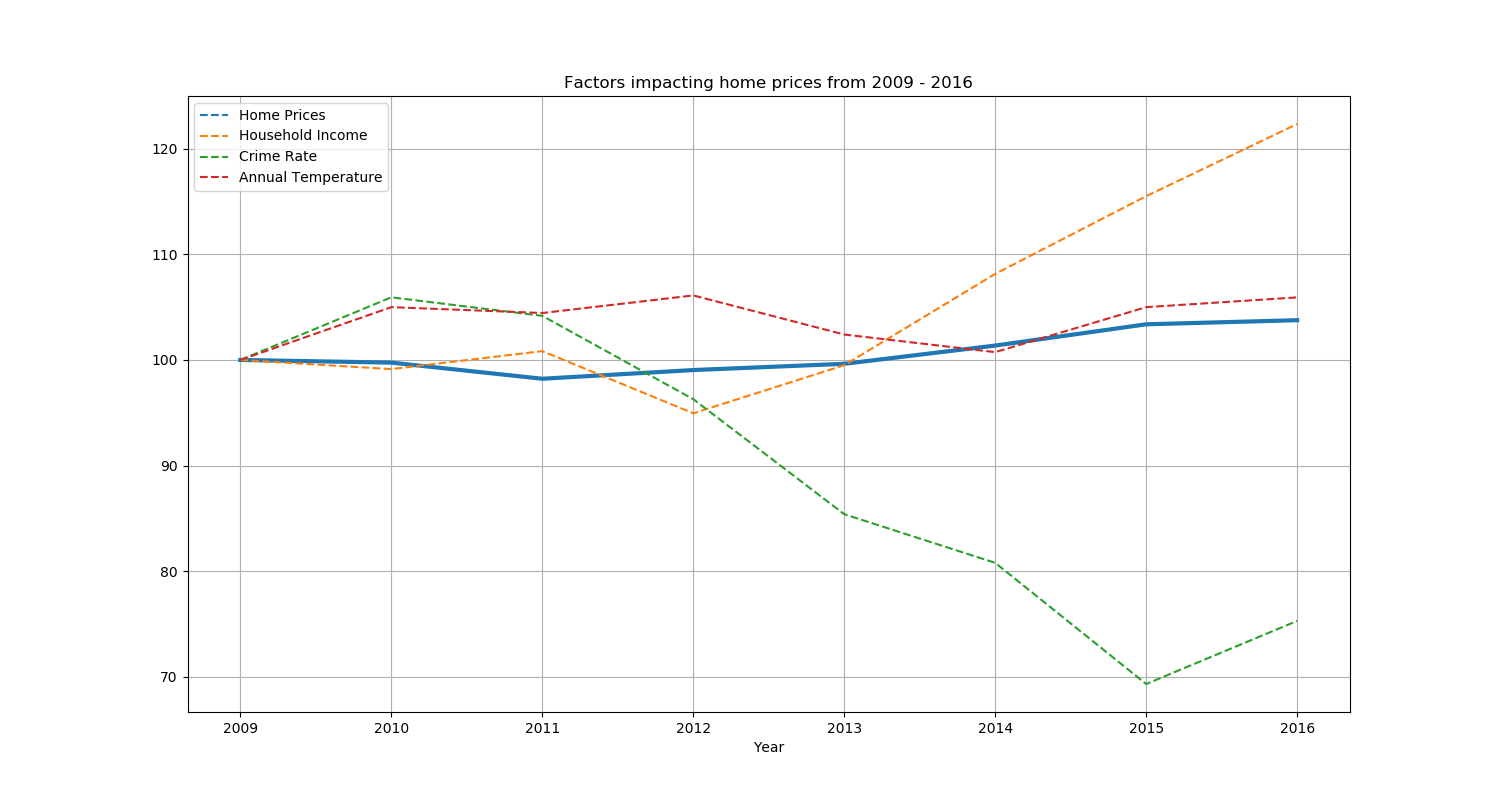

In [88]:
#Plot all the factors on one graph
ax4 = main_ny_df1.plot(title = "Factors impacting home prices from 2009 - 2016", grid=1, ls='--', figsize=(15,8))
line = plt.gca().get_lines()[0]
line.set_ls("-")
line.set_linewidth(3)
plt.savefig("images/11_factors_2009_2016.png", bbox_inches='tight')
plt.show()

In [89]:
main_ny_df.describe()

,Home Prices,Household Income,Crime Rate,Annual Temperature
count,8.000000,8.000000,8.000000,8.000000
mean,258106.760000,52753.875000,0.054068,56.000000
std,5165.643567,4761.049447,0.008357,1.271669
min,251890.580000,47680.000000,0.041803,54.000000
25%,255140.535000,49919.750000,0.047894,55.075000
50%,256131.675000,50426.000000,0.054787,56.550000
75%,261241.520000,55233.750000,0.060942,56.825000
max,266112.370000,61437.000000,0.063891,57.300000


<IPython.core.display.Javascript object>


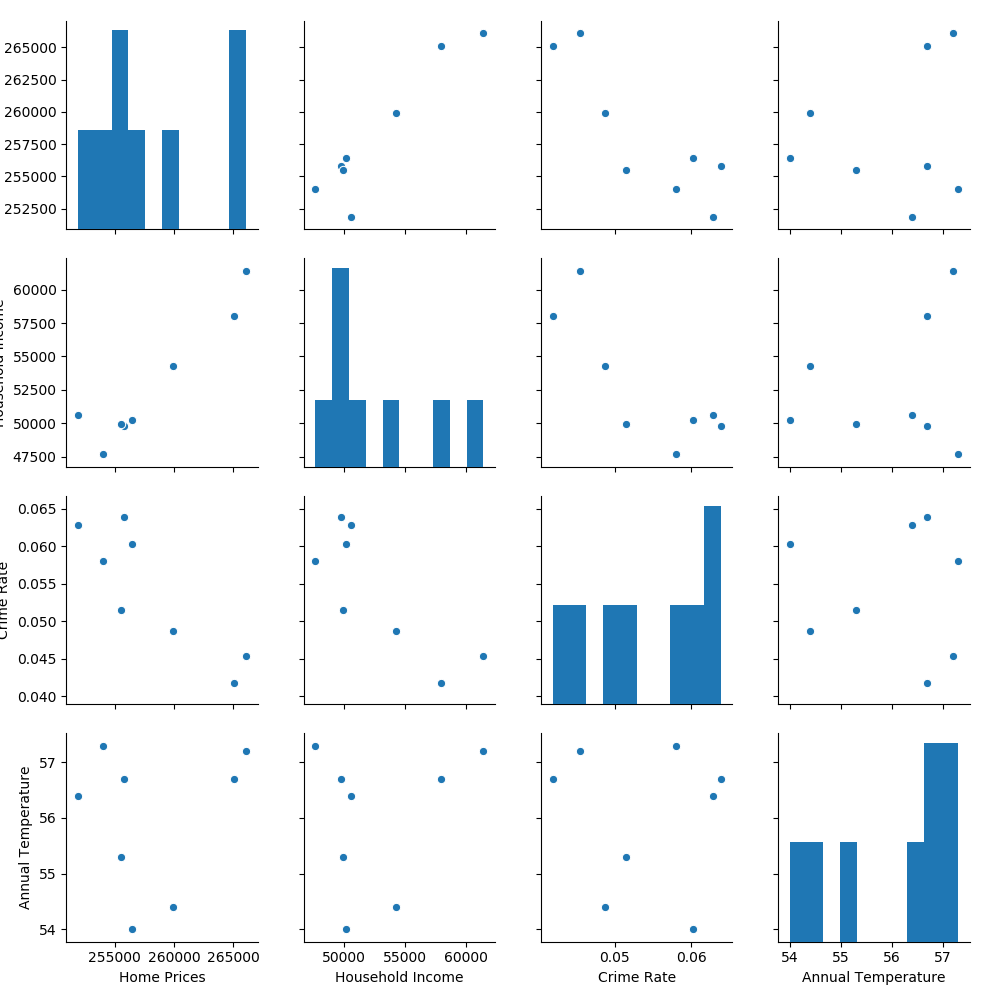

In [90]:
ny_pairplot = sb.pairplot(main_ny_df)
ny_pairplot.savefig("images/12_NY_pair_plot.png")

In [91]:
#Linear Regression Result between Home Prices and Household Income
linregress(main_ny_df['Home Prices'], main_ny_df['Household Income'])

LinregressResult(slope=0.8641227974702729, intercept=-170282.0604971883, rvalue=0.9375559777960977, pvalue=0.0005805612168909876, stderr=0.13088057506870468)

In [92]:
#Linear Regression Result between Home Prices and Crime Rate
linregress(main_ny_df['Home Prices'], main_ny_df['Crime Rate'])

LinregressResult(slope=-1.4043131257419601e-06, intercept=0.4165303424765331, rvalue=-0.8680087138616346, pvalue=0.005194712596140597, stderr=3.279641128850178e-07)

In [93]:
#Linear Regression Result between Home Prices and Weather
linregress(main_ny_df['Home Prices'], main_ny_df['Annual Temperature'])

LinregressResult(slope=3.876459588682571e-05, intercept=45.99459575294209, rvalue=0.1574655316150324, pvalue=0.7095963486644558, stderr=9.924805488123337e-05)

In [94]:
main_ny_corr = main_ny_df.corr()
main_ny_corr

,Home Prices,Household Income,Crime Rate,Annual Temperature
Home Prices,1.000000,0.937556,-0.868009,0.157466
Household Income,0.937556,1.000000,-0.806740,0.214925
Crime Rate,-0.868009,-0.806740,1.000000,-0.074356
Annual Temperature,0.157466,0.214925,-0.074356,1.000000


<IPython.core.display.Javascript object>


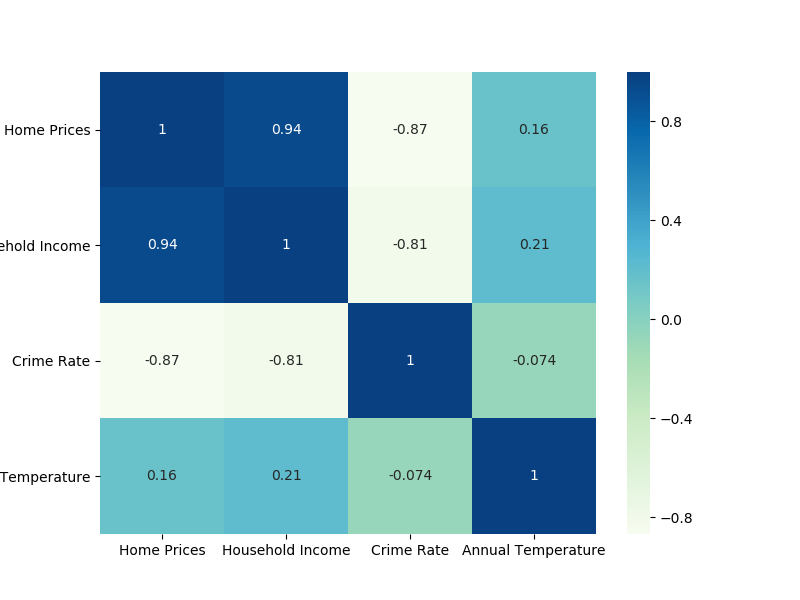

In [95]:
# plot the heatmap
ny_heatmap = plt.figure(figsize=(8,6))
sb.heatmap(main_ny_corr, xticklabels=main_ny_corr.columns, yticklabels=main_ny_corr.columns, cmap='GnBu', annot = True)
ny_heatmap.savefig("images/13_NY_heatmap.png", bbox_inches='tight')

# Prediction

In [96]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [97]:
train1 = main_ny_df2.drop(['Home Prices','Year'],axis=1)
train1 = train1.rename(columns={'Household Income':'HI','Crime Rate':'CR'})
train1

,HI,CR
0,50216,0.060312
1,49781,0.063891
2,50636,0.062831
3,47680,0.058073
4,49966,0.051501
5,54310,0.048723
6,58005,0.041803
7,61437,0.045407


In [98]:
# For simplicity, I’ll be using X and y to denote the feature and target variables.
X = train1
y = main_ny_df2['Home Prices']
y

0    256457.10
1    255806.25
2    251890.58
3    254002.98
4    255519.72
5    259950.50
6    265114.58
7    266112.37
Name: Home Prices, dtype: float64

In [99]:
# Add some extra constant term to allow statsmodels to calculate the bias.
X_constant = sm.add_constant(X)
X_constant

,const,HI,CR
0,1.0,50216,0.060312
1,1.0,49781,0.063891
2,1.0,50636,0.062831
3,1.0,47680,0.058073
4,1.0,49966,0.051501
5,1.0,54310,0.048723
6,1.0,58005,0.041803
7,1.0,61437,0.045407


In [100]:
# Instantiate and fit our model with an ordinary least square model
model = sm.OLS(y, X_constant)
lin_reg = model.fit()

In [101]:
lin_reg.summary()

C:\Users\thidar.tin\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1394: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=8



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Home Prices   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     26.81
Date:                Fri, 08 Mar 2019   Prob (F-statistic):            0.00212
Time:                        18:44:32   Log-Likelihood:                -69.369
No. Observations:                   8   AIC:                             144.7
Df Residuals:                       5   BIC:                             145.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.299e+05   1.91e+04     12.020      0.000    1.81e+05    2.79e+05
HI             0.7374      0.240      3.075      0.028       0.121       1.354
CR         -1.976e+05   1.37e+05     -1.447      0.208   -5.49e+05    1.54e+05
==============================================================================
Omnibus:                        2.209   Durbin-Watson:                   2.412
Prob(Omnibus):                  0.331   Jarque-Bera (JB):                0.722
Skew:                          -0.732   Prob(JB):                        0.697
Kurtosis:                       2.843   Cond. No.                     1.16e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.16e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [102]:
f_model = smf.ols(formula = 'y ~ HI + CR', data=train1)
f_lin_reg = f_model.fit()
f_lin_reg.summary()

C:\Users\thidar.tin\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1394: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=8



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     26.81
Date:                Fri, 08 Mar 2019   Prob (F-statistic):            0.00212
Time:                        18:44:32   Log-Likelihood:                -69.369
No. Observations:                   8   AIC:                             144.7
Df Residuals:                       5   BIC:                             145.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.299e+05   1.91e+04     12.020      0.000    1.81e+05    2.79e+05
HI             0.7374      0.240      3.075      0.028       0.121       1.354
CR         -1.976e+05   1.37e+05     -1.447      0.208   -5.49e+05    1.54e+05
==============================================================================
Omnibus:                        2.209   Durbin-Watson:                   2.412
Prob(Omnibus):                  0.331   Jarque-Bera (JB):                0.722
Skew:                          -0.732   Prob(JB):                        0.697
Kurtosis:                       2.843   Cond. No.                     1.16e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.16e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [103]:
# Predict house prices for 10 years (2009 - 2018)
predict_lin_reg = lin_reg.predict(X_constant[:10])
print(predict_lin_reg)
predict_f_lin_reg = f_lin_reg.predict(X_constant[:10])
print(predict_f_lin_reg)

0    255001.273666
1    253973.334129
2    254813.104519
3    253573.968562
4    256558.375831
5    260310.409276
6    264402.611256
7    266221.002762
dtype: float64
0    255001.273666
1    253973.334129
2    254813.104519
3    253573.968562
4    256558.375831
5    260310.409276
6    264402.611256
7    266221.002762
dtype: float64


In [104]:
from sklearn.metrics import r2_score

In [105]:
# BASE REGRESSION
linear_reg = smf.ols(formula = 'y ~ HI + CR', data=train1)
base = linear_reg.fit()
print(r2_score(y, base.predict(train1)))

0.9147090389953473


In [106]:
# WITHOUT HOUSEHOLD INCOME
linear_reg = smf.ols(formula = 'y ~ CR', data=train1)
base = linear_reg.fit()
print(r2_score(y, base.predict(train1)))

0.7534391273397291


In [107]:
# WITHOUT CRIME RATE
linear_reg = smf.ols(formula = 'y ~ HI', data=train1)
base = linear_reg.fit()
print(r2_score(y, base.predict(train1)))

0.8790112115011972


<IPython.core.display.Javascript object>


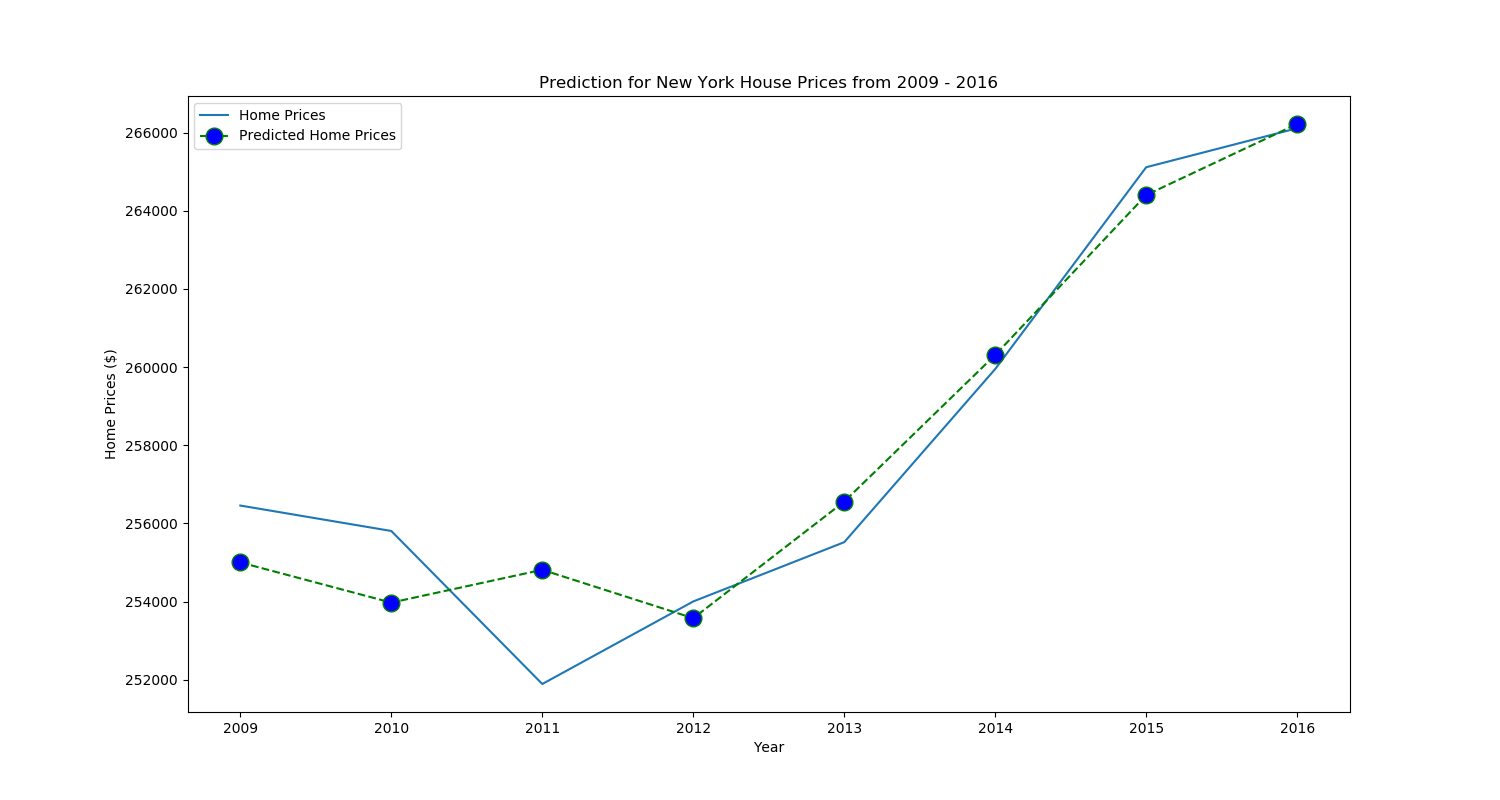

In [108]:
#Plot the prediction and actual house prices on the same plot
main_ny_df2['Predicted Home Prices'] = predict_lin_reg
plt.figure(figsize=(15,8))
plt.plot(main_ny_df2['Year'],main_ny_df2['Home Prices'])
plt.plot(main_ny_df2['Year'],main_ny_df2['Predicted Home Prices'], color='green', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=12)
plt.xlabel('Year')
plt.ylabel('Home Prices ($)')
plt.title('Prediction for New York House Prices from 2009 - 2016')
plt.legend()
plt.savefig("images/14_predict_ny_house_prices_2009_2016.png", bbox_inches='tight')
plt.show()